# Исследование поездок самокатов в сервисе GoFast

В моем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках в сервисе аренды самокатов GoFast. Для совершения поездок по городу, пользователи сервиса GoFast пользуются мобильным приложением.
Данные представлены в виде нескольких таблиц в файлах csv: данные о пользователях, данные о совершенных покздках и виды подписок на сервис.

Необходимо выяснть, что может помочь сервису к получению большей выручки на основе предоставленных данных.

<b>Цель исследования</b>
1. Какие факторы влиют на длительность поездки клиента;
2. Определить является ли платная подписка более выгодна для сервиса, чем бесплатная;
3. Выяснить какие факторы влияют на выбор подписки пользователем;
4. Какие промоакции необходимо предложить клиентам, для увеличения числа платных подписок.

<b>Ход исследования</b>

Данные получены из файлов `users_go.csv`, `rides_go.csv`, `subscriptions_go.csv`. Перед анализом необходимо тщательно проверить их по отдельности на предмет ошибок и аномалий, а также сделать обзий обзор по каждому из параметров, после чего необходимо объеденить все данные для исследования.

Таким образом исследование пройдет в несколько этамов:
1. Выгрузка данных с файлов csv и и предварительное их изучение;
2. Предобработка данных каждого файла;
3. Исследование данных каждого параметра датасета и поиск взаимосвязей;
4. Объединение всех данных;
5. Подсчет помесячной выручки для каждого пользователя;
6. Проверка гипотез;
7. Изучение возможных вариантов увеличения аудитории и количества платных подписок.

# Статистический анализ данных

### Загрузка данных

#### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st

#### Загрузка данных из scv файлов

In [2]:
df_users = pd.read_csv('users_go.csv')

In [3]:
df_rides = pd.read_csv('rides_go.csv')

In [4]:
df_subscriptions = pd.read_csv('subscriptions_go.csv')

#### Вывод фрагментов данных

1. Фрагмент данных пользователей

In [5]:
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


2. Фрагмент данных поездок

In [7]:
df_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


3. Данные подписок

In [9]:
df_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


#### Общий вывод:
- Выгружены все данные из csv файлов;
- Обнаружено 1565 строк данных пользователей;
- Обнаружено 18068 строк данных поездок;
- Обнарыжены 2 типа подписки: бесплатный и платный.

### Предобработка данных

In [11]:
good_df_rides = df_rides.copy()

In [12]:
good_df_users = df_users.copy()

#### Перевод столбца `date` датасета `df_rides` (дата в поездки) в тип pandas

In [13]:
good_df_rides.date = pd.to_datetime(good_df_rides.date)

Данные были получены за 2021 год.

In [14]:
print("Самая ранняя дата: ", min(good_df_rides.date))
print("Самая ранняя дата: ", max(good_df_rides.date))

Самая ранняя дата:  2021-01-01 00:00:00
Самая ранняя дата:  2021-12-30 00:00:00


#### Создаем столбец  `date_month` датасета `df_rides` (месяц поездки)

In [15]:
good_df_rides['date_month'] = good_df_rides.date.dt.month

#### Обработка пропусков в датасетах  `df_users` и `df_rides` 

1. Явных пропусков датасетов `df_users` и `df_rides` со значением `NaN` не найдено.

In [16]:
good_df_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [17]:
good_df_rides.isna().sum()

user_id       0
distance      0
duration      0
date          0
date_month    0
dtype: int64

2. Неявных пропусков в датасете `df_users` не найдено.

In [18]:
print(list(good_df_users.age.unique()))

[22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17, 12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43]


In [19]:
print(list(good_df_users.city.unique()))

['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар', 'Пятигорск', 'Екатеринбург', 'Сочи']


In [20]:
print(list(good_df_users.subscription_type.unique()))

['ultra', 'free']


In [21]:
len(good_df_users[df_users.name == ''])

0

3. Неявных пропусков в датасете `df_rides` также не найдено.

In [22]:
len(good_df_rides[df_rides.distance == 0])

0

In [23]:
len(good_df_rides[df_rides.duration == 0])

0

#### Обработка дубликтов  в датасетах `df_users` и `df_rides` 

1. Вычислим количество неявных дубликатов в датасете `df_users`.

In [24]:
good_df_users.duplicated().sum()

31

Отфильтруем явные дубликаты.

In [25]:
good_df_users = good_df_users.drop_duplicates()

In [26]:
len(df_users.user_id)

1565

In [27]:
len(good_df_users.user_id)

1534

2. Вычислим количество неявных дубликатов в датасете `df_rides`, учитывая столбцы `distance`, `duration`, `date`. Дубликатов не было найдено.

In [28]:
good_df_rides.duplicated(subset=['distance', 'duration', 'date']).sum()

0

#### Округлим значения дистанции и длительности поездок

Длительность поездок округлим до 1 цифры после запятой (0.1 минута = 6 секундам)
<br>Расстояние поездок округлим до целого значения.

In [29]:
good_df_rides.duration = good_df_rides.duration.round(1)

In [30]:
good_df_rides.distance = good_df_rides.distance.round(0)

In [31]:
good_df_rides.duration

0        25.6
1        15.8
2         6.2
3        18.5
4        26.3
         ... 
18063    19.8
18064    21.4
18065    18.4
18066    16.7
18067    15.9
Name: duration, Length: 18068, dtype: float64

In [32]:
good_df_rides.distance

0        4410.0
1        2618.0
2         754.0
3        2695.0
4        4029.0
          ...  
18063    3781.0
18064    2840.0
18065    3826.0
18066    2902.0
18067    2372.0
Name: distance, Length: 18068, dtype: float64

#### Общий вывод предобработки данных

Проведена предобраотка данных, в ходе которой:
1. В датасетах пользователей изменен тип столбца `date` на `datetime64[ns]`;
2. Создан столбец `date_month` месяца поездки;
3. Не обнаружено пропусков в датасетах пользователей и поездах;
4. Отфильтрованы неявные дубликаты в датасете пользователей;
5. Не обнаружено явных и неявных дубликатов в столбце поездок;
6. Округлены значения расстояния и длительности поездок.

### Исследовательский анализ данных

#### Частота встречаемости городов

Выведем количество пользователей, сгрупированных по городам. Из данных мы видим, что меньше всего пользователей у Москвы (168), больше всего в Пятегорске (214).

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: count, dtype: int64


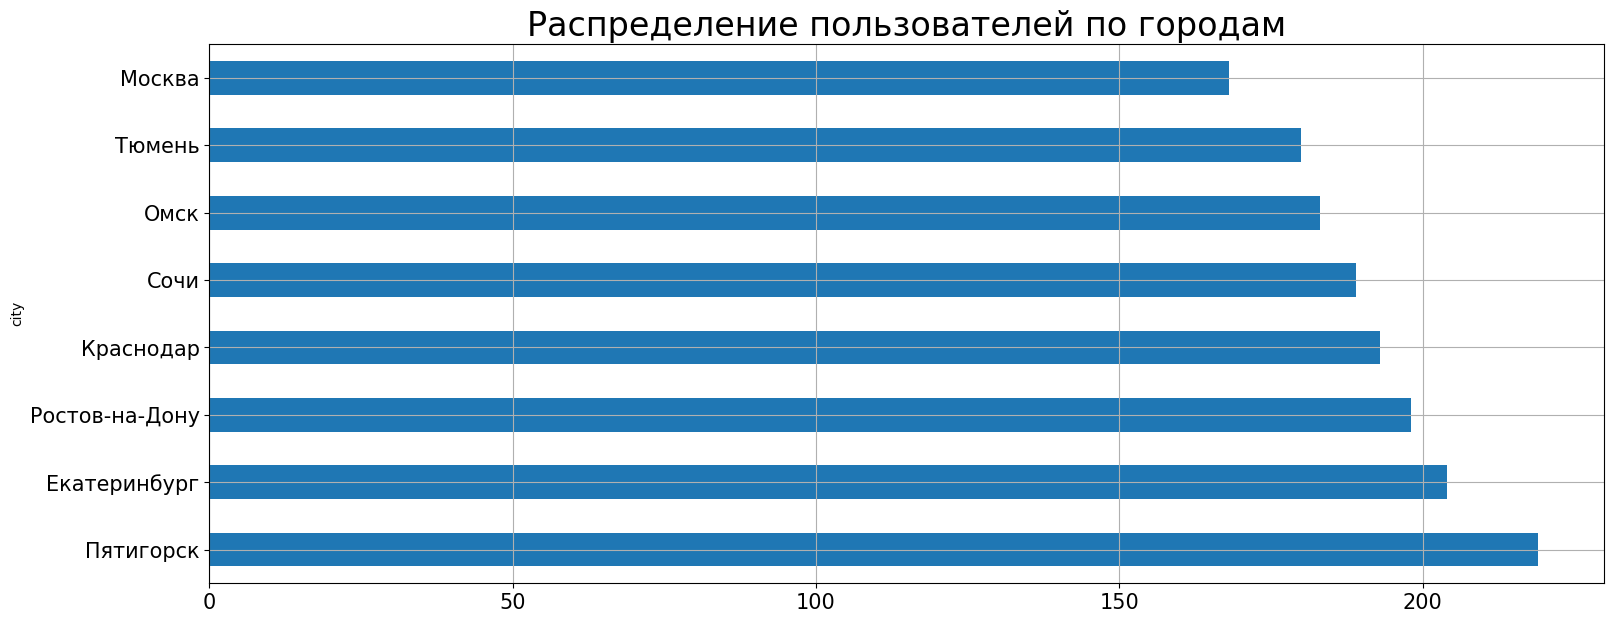

In [33]:
df_cities = good_df_users.city.value_counts()
print(df_cities.sort_values())
ax = (
    df_cities
        .plot.barh(grid=True, figsize=(18, 7), fontsize=15)
        .set_title('Распределение пользователей по городам', fontsize=24)
)

<b>Вывод:</b>
- Больше всего пользователей сервиса живут в Пятегорске (214);
- Меньше всего пользователей сервиса живут в Москве (167);
- Не найдено никаких выбросов пользователей ни в ккаком городе. Разница количества пользователей в Пятегорске и Москве равна 47.

#### Соотношение пользователей с подпиской и без подписки

Выведем количество подписок. Из данных и графика мы видим, что 46 процентов пользователей сервиса приобрели платную подписку.

subscription_type
free     835
ultra    699
Name: count, dtype: int64


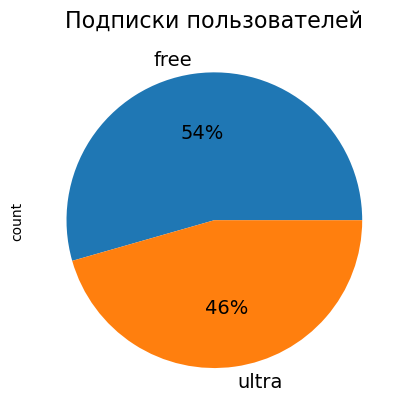

In [34]:
print(good_df_users.subscription_type.value_counts())
ax = good_df_users.subscription_type.value_counts().plot.pie(fontsize=14, autopct='%1.0f%%')
res = ax.set_title('Подписки пользователей', fontsize=16)

Вычислим количества и доли платных подписок по городам, из которого можно сделать вывод, что пользователи из Москвы и Омска берут чаще платные подписки, чем в других городах, в Пятегорске и Краснодаре меньше реже всего.

In [35]:
df_city_subs = ( 
    pd.pivot_table(
        df_users, 
        index='city', 
        columns='subscription_type', 
        values='user_id', 
        aggfunc='count'
    )
)
df_city_subs['ultra_share'] = df_city_subs['ultra'] / (df_city_subs['ultra'] + df_city_subs['free'])
df_city_subs.sort_values(by='ultra_share', ascending=False)

subscription_type,free,ultra,ultra_share
city,,,
Москва,84,88,0.511628
Омск,92,94,0.505376
Тюмень,100,85,0.459459
Сочи,104,88,0.458333
Екатеринбург,114,92,0.446602
Ростов-на-Дону,112,90,0.445545
Пятигорск,128,98,0.433628
Краснодар,112,84,0.428571


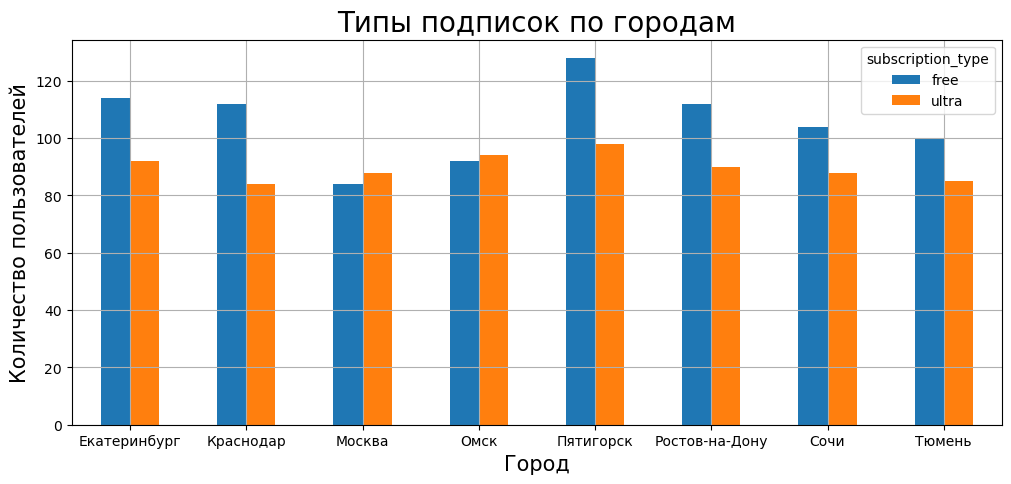

In [36]:
ax = df_city_subs[['free', 'ultra']].plot.bar(figsize=(12, 5), rot=0, grid=True)
res = ax.set_title('Типы подписок по городам', fontsize=20)
res = ax.set_xlabel('Город', fontsize=15)
res = ax.set_ylabel('Количество пользователей', fontsize=15)

<b>Вывод:</b>
- Пользователи с платной подпиской равномерно распеределены по городам (от 84 до 94 пользователей);
- Пользователи из Москвы и Омска берут чаще платные подписки, чем в других городах при меньшем количестве обхих пользователей;
- Пользователи из Краснодара и Пятегорска берут реже платные подписки, чем в других городах при большем количестве обхих пользователей.

#### Возраст пользователей

Изучим возраст пользователей. Мы видим, что средний возраст близок к медиане, а стандратное отклонение примерно равна 4,5 годам, их чего мы можем сделать вывод, что возраст пользователей нормально распределена.

In [37]:
good_df_users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

По распределению пользователей по возрасту мы видим нормальное распределение с модой 25 лет.

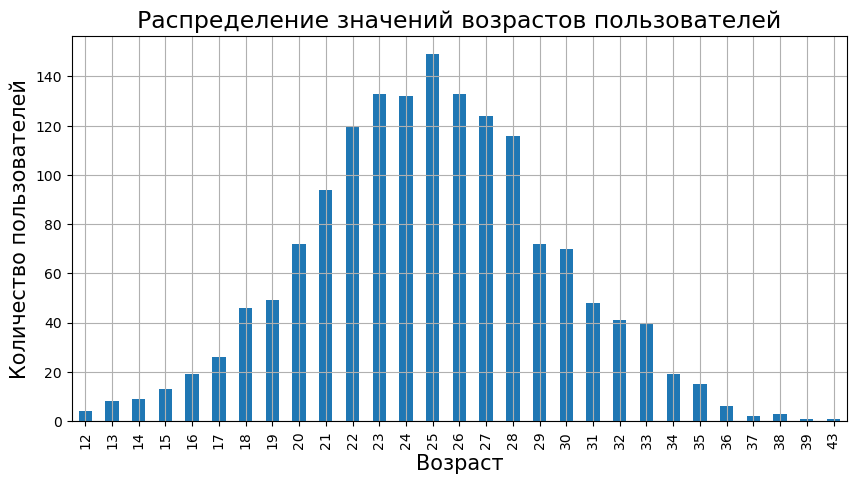

In [38]:
ax = df_users.age.value_counts().sort_index().plot.bar(x='index', figsize=(10, 5), grid=True)
res = ax.set_xlabel("Возраст", fontsize=15)
res = ax.set_ylabel("Количество пользователей", fontsize=15)
res = ax.set_title("Распределение значений возрастов пользователей", fontsize=17)

Средний возраст пользователей с подпиской чуть выше, чем пользователи без подписки, что дает нам мало информации о зависимости подписки к возрасту.

In [39]:
print('Средний возраст пользователей без подписки: %.2f' % 
      good_df_users[good_df_users.subscription_type == 'free'].age.mean()
)
print('Средний возраст пользователей с подпиской: %.2f' % 
      good_df_users[good_df_users.subscription_type == 'ultra'].age.mean()
)

Средний возраст пользователей без подписки: 24.87
Средний возраст пользователей с подпиской: 24.94


Построим распределения возрастов пользователей, сгрупированных по типу подписки. Из него мы видим, что оснавная группа пользователей сервиса (до 30 лет) больше предпочитают не брать платную подписку (исключение 15, 19 и 29 лет).Пользователи от 31 года предпочитают чаще брать платные подписки.

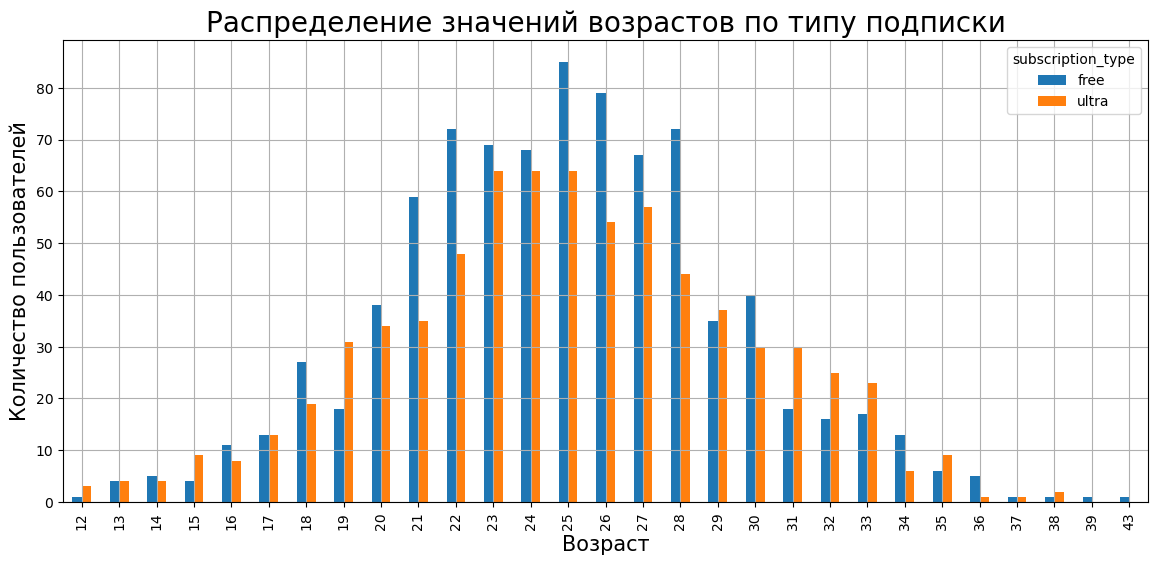

In [40]:
ax = pd.pivot_table(
    df_users,
    index = 'age',
    columns = 'subscription_type',
    values='user_id',
    aggfunc ='count',
).plot.bar(figsize=(14, 6), grid=True)
res = ax.set_title("Распределение значений возрастов по типу подписки", fontsize=20)
res = ax.set_xlabel("Возраст", fontsize=15)
res = ax.set_ylabel("Количество пользователей", fontsize=15)

Изучим средний возраст пользователей по городам с учетом подписок. построим таблицу возрастов и столбчиковую диаграму.
<br>Из него мы видим, средний возраст без подписки выше всех в Москве (примерно 25.6 лет).
<br>Из него мы видим, средний возраст с подпиской выше всех в Краснодаре (примерно 26.2 года).
<br>Из него мы видим, средний возраст без подписки меньше всех в Ростове-на-Дону (примерно 24.4 года).
<br>Из него мы видим, средний возраст с подпиской выше всех в Пятигорске (примерно 24.4 года).

subscription_type  free  ultra
city                          
Екатеринбург       25.1   24.8
Краснодар          24.6   26.2
Москва             25.5   25.0
Омск               25.1   25.6
Пятигорск          25.0   24.3
Ростов-на-Дону     24.4   24.7
Сочи               24.7   24.3
Тюмень             24.7   24.6


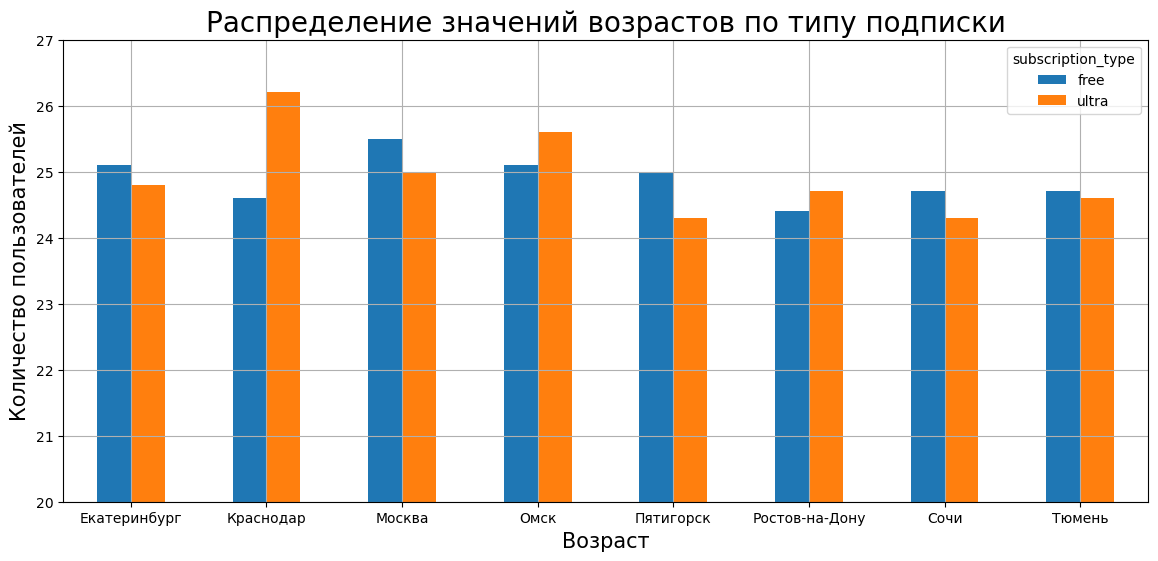

In [41]:
df_city_age = pd.pivot_table(
    good_df_users,
    index = 'city',
    columns = 'subscription_type',
    values='age',
    aggfunc ='mean',
)
df_city_age = df_city_age.round(1)
print(df_city_age)
ax = df_city_age.plot.bar(figsize=(14, 6), grid=True, rot=0, ylim=(20, 27))
res = ax.set_title("Распределение значений возрастов по типу подписки", fontsize=20)
res = ax.set_xlabel("Возраст", fontsize=15)
res = ax.set_ylabel("Количество пользователей", fontsize=15)

<b>Вывод:</b>
- Возраст пользователей нормально распределена с средним (с учетом округления) и медианной равна 25 годам;
- Пользователи до 30 лет чаще предпочитают не брать подписку;
- Пользователи после 30 лет чаще предпочитают брать мещачную подписку;
- Средний возраст пользователей с платной подпиской и без отличаются в каждом городе друго от друга;
- Cредний возраст без подписки выше всех в Москве (25.6 лет);
- Cредний возраст с подпиской выше всех в Краснодаре (26.2 года);
- Cредний возраст без подписки меньше всех в Ростове-на-Дону (24.4 года);
- Cредний возраст с подпиской выше всех в Пятигорске (24.4 года).

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Основная часть пользователей возрастом от 22 до 28 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

#### Продолжительность поездок

Изучим гистограмму длительности поездок. 
<br>Мы видим нормальное распределение со средним значеним в 17.8 минут и стандартным отклонением 6 минут.
<br>Однако виден странный небольшой пик с значением близким к 0.

count    18068.000000
mean        17.804920
std          6.091365
min          0.500000
25%         13.600000
50%         17.700000
75%         21.700000
max         40.800000
Name: duration, dtype: float64


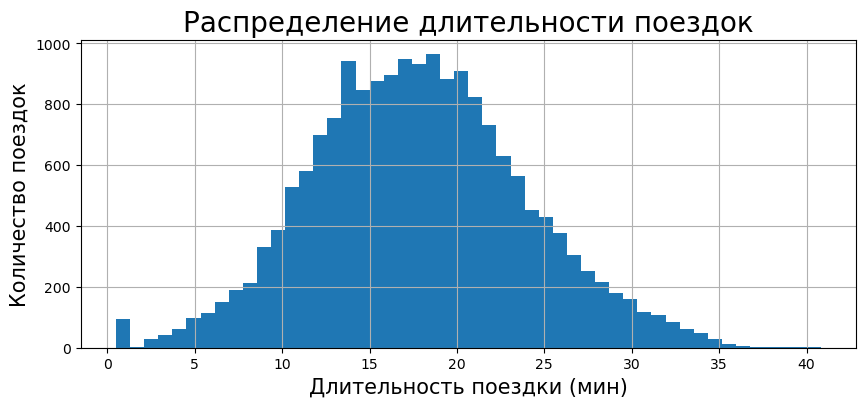

In [42]:
print(good_df_rides.duration.describe())
ax = good_df_rides.duration.hist(bins=50, figsize=(10, 4))
res = ax.set_title('Распределение длительности поездок', fontsize=20)
res = ax.set_xlabel("Длительность поездки (мин)", fontsize=15)
res = ax.set_ylabel("Количество поездок", fontsize=15)

Построим график рассеивания значений между дистанцией и длительностью поездок. Из него видна зависимость растояния от дистанцией со смещением по времени поездок, скорее всего обусловенных временем на началом и окончанием поездки и необходимостью взаимодействовать с приложением.
<br><br>
Также можно обнаружить на отметке в 1500 метров, что пездки с расстоянием в 1500 метров редки.
<br><br>
Однако также уже четко видна аномалия из гистограмма с поездками, у которых длительность поездки примерно равна 0.

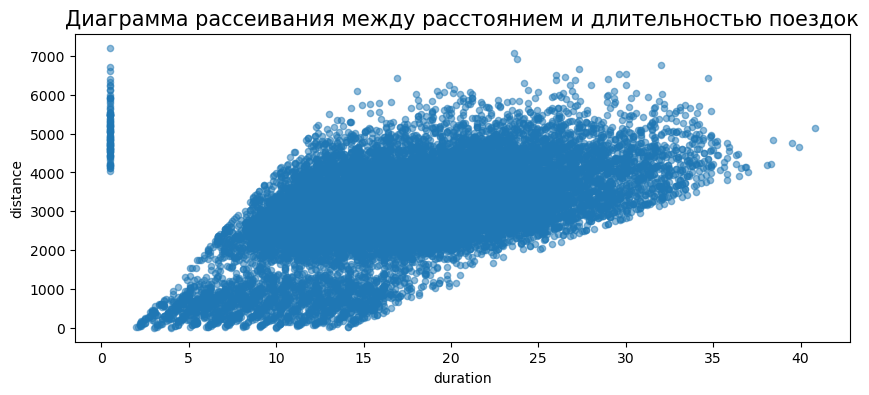

In [43]:
ax = good_df_rides.plot(kind='scatter', x='duration', y='distance', figsize=(10, 4), alpha=0.5)
res = ax.set_title('Диаграмма рассеивания между расстоянием и длительностью поездок', fontsize=15)

Укрупним эти начения и увидим, что длительность поездки составляет 30 секунд.
Причиной технической неполадки может быть, баги возвращения потери данных длительности поездок в мобильнрм приложении или ее сервисе. Как решение следует отфильтровать их, чтоб сохранить корректность данных.

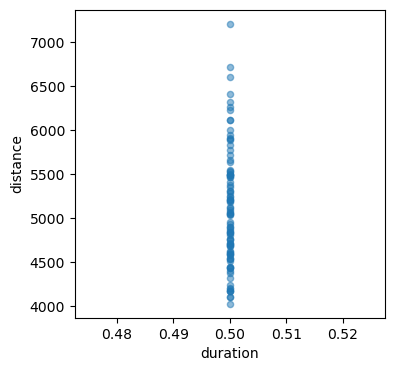

In [44]:
ax = (
    good_df_rides.query('duration < 1')
        .plot(kind='scatter', x='duration', y='distance', figsize=(4, 4), alpha=0.5)
)

In [45]:
len(good_df_rides.query('duration <= 1'))

95

<b>Вывод:</b>
- Найдена аномалия в столбце длительности поездок;
- Обнаружена прямая зависимость растояния от дистанцией со смещением по времени поездок для отсановок.

#### Расстояние, которое пользователь преодолел за одну поездку

Построим гистограмму расстояния отдельны поездок.
Мы видим график с двумя пиками (примерно 350 метров и 3100 метров) и локальным провалом поездок с расстоянием 1500 метров.

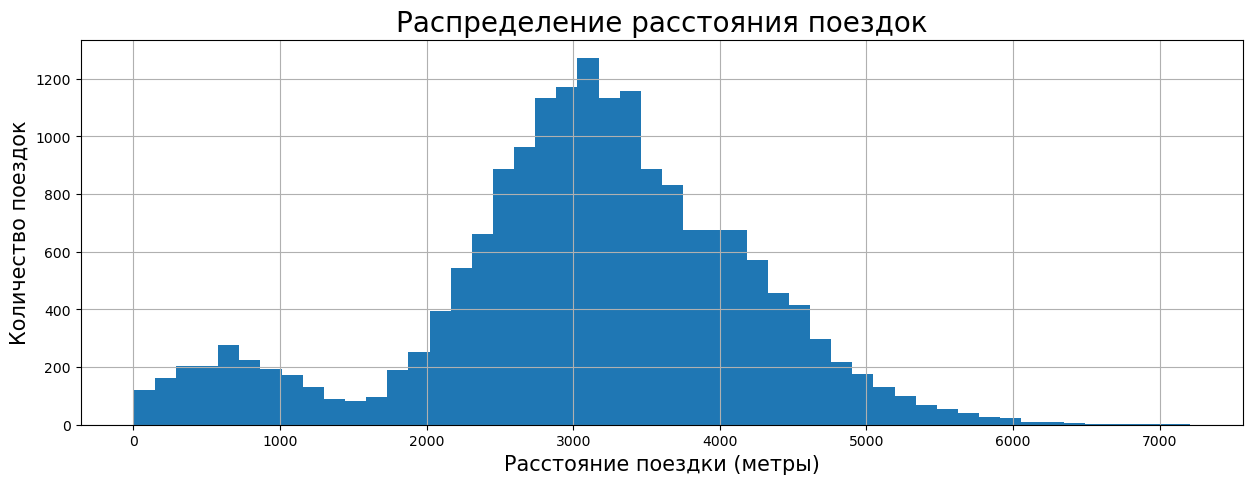

In [46]:
ax = good_df_rides.distance.hist(bins=50, figsize=(15, 5))
res = ax.set_title('Распределение расстояния поездок', fontsize=20)
res = ax.set_xlabel("Расстояние поездки (метры)", fontsize=15)
res = ax.set_ylabel("Количество поездок", fontsize=15)

<b>Вывод:</b>
- Из расспределения по дистанци можно обнаружить две группы поездок: короткие (1500 метров) и длинные (более 1500 метров).
- Наиболее частые поедки имеют расстояния предаления в 3000-3100 метров;

### Шаг 4. Объединение данных

#### Объедините данные о пользователях, поездках и подписках в один датафрейм. 

Проверим размеры датасетов до их объединения.

In [47]:
len(good_df_users.user_id)

1534

In [48]:
len(good_df_rides.user_id)

18068

In [49]:
len(df_subscriptions.subscription_type)

2

In [50]:
good_df_all = good_df_users.merge(df_subscriptions, on='subscription_type')
good_df_all = good_df_all.merge(good_df_rides, on='user_id')
good_df_all.sample(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,date_month
1557,167,Захар,35,Ростов-на-Дону,ultra,6,0,199,3584.0,17.8,2021-06-10,6
10595,999,Богдан,23,Тюмень,free,8,50,0,2983.0,23.5,2021-07-21,7
2474,262,Яна,27,Сочи,ultra,6,0,199,874.0,7.6,2021-12-14,12
5093,548,Степан,15,Омск,ultra,6,0,199,3127.0,21.7,2021-03-12,3
10586,998,Анна,22,Тюмень,free,8,50,0,2441.0,16.4,2021-09-19,9


Результирующий датафрейм совпадает по количество строк с датасетом поездок, поэтому все данные объединились корректно.

In [51]:
len(good_df_all.user_id)

18068

#### Создание отдельных датафремов для пользователей с подпиской и без

In [52]:
good_df_free = good_df_all[good_df_all.subscription_type == 'free']

In [53]:
good_df_free.sample(3)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,date_month
10576,998,Анна,22,Тюмень,free,8,50,0,3881.0,24.6,2021-01-10,1
7232,751,Григорий,21,Сочи,free,8,50,0,4933.0,17.8,2021-03-07,3
12076,1107,Инна,22,Краснодар,free,8,50,0,4064.0,16.4,2021-09-18,9


In [54]:
good_df_ultra = good_df_all[good_df_all.subscription_type == 'ultra']

In [55]:
good_df_ultra.sample(3)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,date_month
1656,177,Данил,25,Краснодар,ultra,6,0,199,3204.0,17.9,2021-08-09,8
2077,223,Игорь,25,Тюмень,ultra,6,0,199,2316.0,10.7,2021-05-10,5
4472,482,Ясмина,22,Пятигорск,ultra,6,0,199,2809.0,13.4,2021-10-29,10


#### Изучение времени и дистанции поездок в зависимости от подписки

Построим гистограммы расстояния и дистанции поездок.
<br><br>
Из гистограммы расстояния поездок видно, что короткие поездки пользователей с платной подпиской распределены от 300 до 2000 метров с пиков на 100 метров.

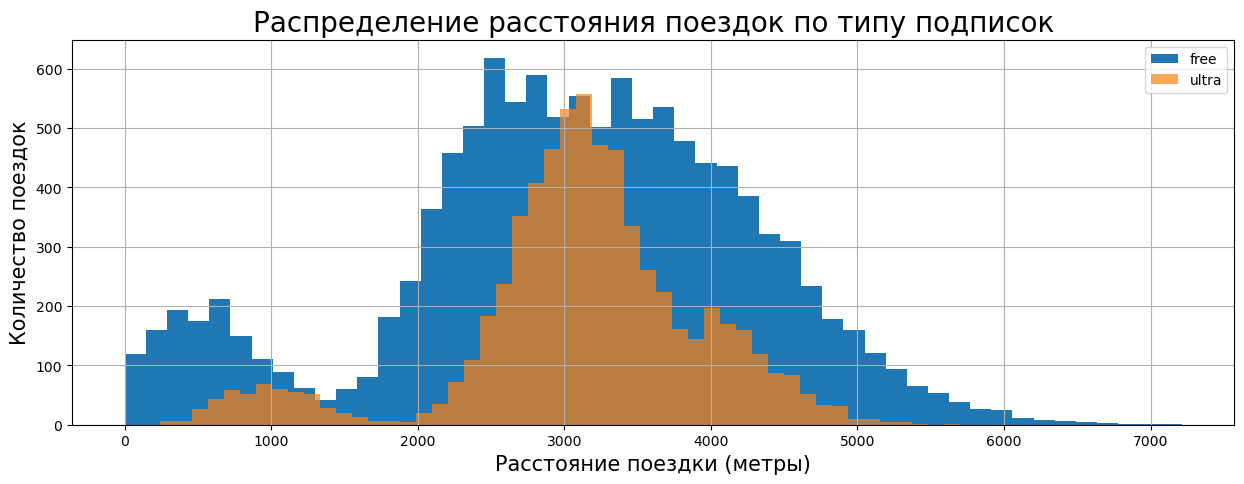

In [56]:
ax = good_df_free.distance.hist(bins=50, figsize=(15, 5))
ax = good_df_ultra.distance.hist(bins=50, figsize=(15, 5), ax=ax, alpha=0.7)
res = ax.legend(['free', 'ultra'])
res = ax.set_title('Распределение расстояния поездок по типу подписок', fontsize=20)
res = ax.set_xlabel("Расстояние поездки (метры)", fontsize=15)
res = ax.set_ylabel("Количество поездок", fontsize=15)

In [57]:
good_df_free.distance.describe()

count    11568.00000
mean      3045.49490
std       1246.17418
min          1.00000
25%       2367.00000
50%       3115.00000
75%       3906.00000
max       7211.00000
Name: distance, dtype: float64

In [58]:
good_df_ultra.distance.describe()

count    6500.000000
mean     3115.443385
std       836.898137
min       244.000000
25%      2785.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64

Гистограммы поездок с подпиской и без примерно схожи по форме, похожее на нормальное распределение без учета коротких покздок. 
<br><br>
Самая короткая поездка без подписки составляет 1 метр, в то время как самая минимальной поездке с подпиской составляет 244 метров.
<br><br>
Самая длинная поездка занимает 7 с лишним километров, что может сильно изнасить самокат.
<br><br>
Построим рассеивания для поездок с растоянием менее 250 метров, где можно увидеть, что очень короткие поездки рассеяны от 2 до 15 минут. Такое время может быть обусловлено долгим взаимодействием с сервисом через мобильное приложение.

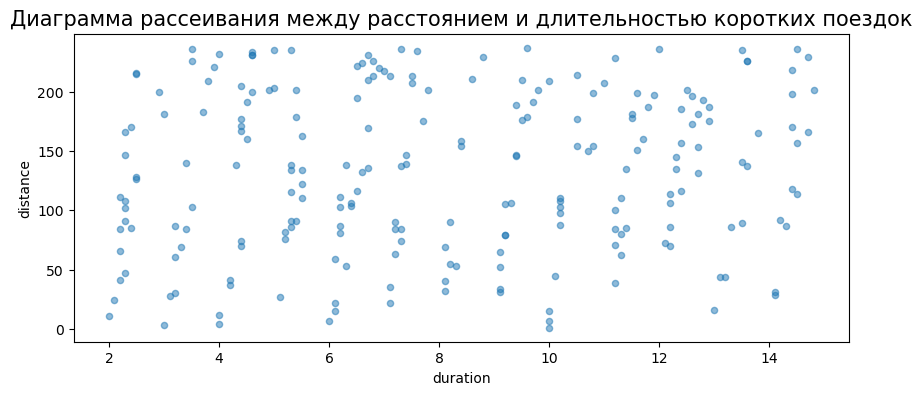

In [59]:
ax = (
    good_df_rides.query('distance < 240').plot(kind='scatter', x='duration', y='distance', figsize=(10, 4), alpha=0.5)
)
res = ax.set_title('Диаграмма рассеивания между расстоянием и длительностью коротких поездок', fontsize=15)

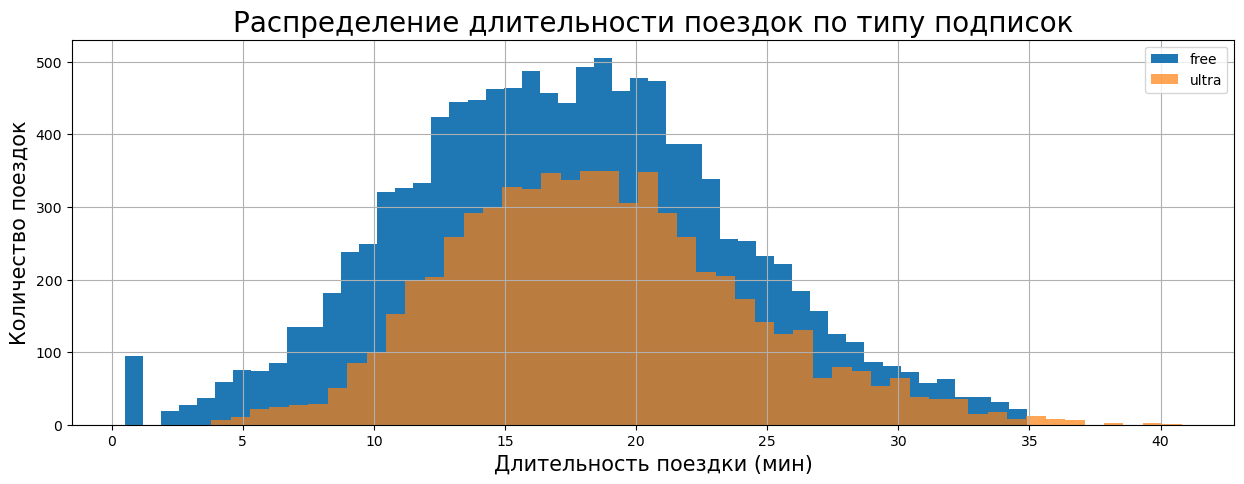

In [60]:
ax = good_df_free.duration.hist(bins=50, figsize=(15, 5))
ax = good_df_ultra.duration.hist(bins=50, figsize=(15, 5), ax=ax, alpha=0.7)
res = ax.legend(['free', 'ultra'])
res = ax.set_title('Распределение длительности поездок по типу подписок', fontsize=20)
res = ax.set_xlabel("Длительность поездки (мин)", fontsize=15)
res = ax.set_ylabel("Количество поездок", fontsize=15)

<b>Вывод:</b>
- Объеденены датасеты пользователей, подписок и поездок в один единый датасет;
- Короткие поездки пользователей с платной подпиской распределены от 300 до 2000 метров с пиков на 100 метров;
- Локальных пик частоты коротких поездок (до 1500 метров) для пользователей <u>БЕЗ ПОДПИСКИ</u> раны находится на отметке 700 метров;
- Локальных пик частоты коротких поездок (до 2000 метров) для пользователей <u>С ПОДПИСКОЙ</u> раны находится на отметке 100 метров;
- Длительность поездок пользователей с подпиской и без распределены нормально.

### Шаг 5. Подсчёт выручки

#### Аггрегированные данные о поездках по пользователю

1. Вычисляем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, где была хоть одна поездка.

In [61]:
good_df_all.duration = good_df_all.duration.apply(np.ceil).astype('int')

df_user_rides = pd.pivot_table(
    good_df_all,
    index = ['user_id', 'date_month'],
    values = ['distance', 'duration'],
    aggfunc = { 'distance': ['sum'],  'duration': ['sum', 'count'] },
)
df_user_rides.columns = ['distance', 'count', 'duration']
df_user_rides.distance = df_user_rides.distance.astype('int')
df_user_rides.head(10)

distance  count  duration
user_id date_month                           
1       1               7028      2        42
        4                754      1         7
        8               6724      2        46
        10              5810      2        32
        11              7004      3        55
        12              6752      2        28
2       3              10188      3        63
        4               6165      2        40
        6               3255      1        14
        7               6781      2        47

По информации сводной таблицы явных пропусков найлено не было, ввсе столбцы заполнены значениями.

In [62]:
df_user_rides.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   distance  11331 non-null  int64
 1   count     11331 non-null  int64
 2   duration  11331 non-null  int64
dtypes: int64(3)
memory usage: 310.9 KB


Неявных пропусков также не найдено.

In [63]:
len(df_user_rides[df_user_rides.distance == 0])

0

In [64]:
len(df_user_rides[df_user_rides.duration == 0])

0

In [65]:
len(df_user_rides[df_user_rides['count'] == 0])

0

2. Добавляем к полученному датасету цену за минуту, стартовую стоимость поездки, стоимость подписки и тип подписки.

In [66]:
columns = ['minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
user_subs = pd.pivot_table(
    good_df_all,
    index = ['user_id', 'date_month'],
    values = columns,
    aggfunc = 'first',
)
df_user_rides[columns] = user_subs[columns]
df_user_rides.sample(5)

,,distance,count,duration,minute_price,start_ride_price,subscription_fee,subscription_type
user_id,date_month,,,,,,,
1003,6,2436,1,10,8,50,0,free
835,4,4854,2,35,8,50,0,free
526,6,2923,1,25,6,0,199,ultra
1206,2,2656,1,13,8,50,0,free
1366,5,2545,1,19,8,50,0,free


####  Добавляем столбец с помесячной выручкой, которую принёс каждый пользователь
Вычислим суммарную вырочку за каждого пользователя за каждый месяц.

In [67]:
df_user_rides['total_cost'] = (
    df_user_rides['start_ride_price'] * df_user_rides['count'] +
    df_user_rides['minute_price'] * df_user_rides['duration'] +
    df_user_rides['subscription_fee']
)
df_user_rides.sample(5)

,,distance,count,duration,minute_price,start_ride_price,subscription_fee,subscription_type,total_cost
user_id,date_month,,,,,,,,
584,5,3121,1,26,6,0,199,ultra,355
983,12,6906,2,32,8,50,0,free,356
1385,6,507,1,10,8,50,0,free,130
996,2,7562,2,39,8,50,0,free,412
1209,2,7972,2,41,8,50,0,free,428


#### Вывод
- Cформирован датасет из всех исходны данных пользователей, подписках и поездках;
- Добавлен столбец суммарной выручки каждого пользователя в кайждый месяц 2021 года.

### Проверка гипотез

#### Гипотеза. Тратят ли пользователи с подпиской больше времени на поездки? 

Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам (столбец `df_rides` в датасетах `df_free` и `df_ultra`): 
<br>Перед t-test проверим необходимые условия:
- <u>Генеральные совокупности не зависят друг от друга</u>, поскольку данные длительности относятся к разным групам пользователей, зависящих от типа подписки;
- <u>Выборочные средние нормально распределены</u> из-за закона ЦПТ;
- <u>Дисперсии рассматриваемых генеральных примерно равны</u> и совокупностей отличаются на 0.75 (меньше минуты).

In [68]:
good_df_free.duration.std()

6.327256080859964

In [69]:
good_df_ultra.duration.std()

5.572125819590608

Все необходимые условия соблюдены, поэтому проверим одностороннюю гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.
- <i>H0</i>: Средняя длительность поездок пользователей с подпиской и без равны;
- <i>H1</i>: Средняя длительность поездок пользователей подпиской больше, чем пользователей без подписки.

In [70]:
alpha = 0.01 # заданный уровень значимости
results = (
    st.ttest_ind(
        good_df_ultra.duration, 
        good_df_free.duration, 
        equal_var=True, 
        alternative='greater'
    )
)
print(f'p-value: {results.pvalue}\n')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу:')
    print('Длительность поездки у пользователей с подпиской выше, чем у пользователей без подписки.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.3448182372889e-34

Отвергаем нулевую гипотезу:
Длительность поездки у пользователей с подпиской выше, чем у пользователей без подписки.


<b>Вывод:</b> Длительность поездки у пользователей с подпиской выше, чем у пользователей без подписки.

#### Гипотеза. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Проверим одностороннюю гипотезу о равенстве среднего расстояния поездки пользователей с подписки со значением 3130 метров.
- <i>H0</i>: Средняя длительность поездок пользователей с подпиской равна 3130 метров;
- <i>H1</i>: Средняя длительность поездок пользователей с подпиской больше 3130 метров.

In [71]:
alpha = 0.01 # заданный уровень значимости
interested_value = 3130
results = st.ttest_1samp(good_df_ultra.distance, interested_value, alternative='greater')

print(f'p-value: {results.pvalue}\n')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу:')
    print('Пользователи с подпиской не изнашивают самокаты.')

p-value: 0.9195649894697724

Нет оснований отвергнуть нулевую гипотезу:
Пользователи с подпиской не изнашивают самокаты.


<b>Вывод:</b> Пользователи с подпиской не изнашивают самокаты.

#### Гипотеза. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Перед проверкой гипотезы разобъем данный выручки на два массива. Для пользователей без подписки и с подпиской.

In [72]:
total_cost_free = df_user_rides[df_user_rides['subscription_type'] == 'free'].total_cost
total_cost_ultra = df_user_rides[df_user_rides['subscription_type'] == 'ultra'].total_cost

print("Среднеквадратичное отклонение помесячной выручки для пользователей:")
print('без подписки - {:.0f}'.format(total_cost_free.std()))
print('c подпиской - {:.0f}'.format(total_cost_ultra.std()))

Среднеквадратичное отклонение помесячной выручки для пользователей:
без подписки - 183
c подпиской - 88


Значение дисперсий отличается более чем на 100 метров, поэтому в методе `ttest_ind` указываем параметр `equal_var=False`.
<br><br>Проверим одностороннюю гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.
- <i>H0</i>: Помесячная выручкка с пользователей с подпиской равна помесячной выручкке с пользователей без подпискки;
- <i>H1</i>: Помесячная выручкка с пользователей с подпиской выше помесячной выручкке с пользователей без подпискки.

In [73]:
alpha = 0.01 # заданный уровень значимости
results = st.ttest_ind(total_cost_ultra, total_cost_free, equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}\n')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
    print('Помесячная выручкка с пользователей с подпиской выше помесячной выручкке с пользователей без подпискки.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.6347563038803448e-40

Отвергаем нулевую гипотезу.
Помесячная выручкка с пользователей с подпиской выше помесячной выручкке с пользователей без подпискки.


<b>Вывод:</b> Помесячная выручкка с пользователей с подпиской выше помесячной выручкке с пользователей без подпискки.

#### Вопрос
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<b>Ответ:</b> 
<br> Необходимо проверить гипотезу о равенстве о равенстве средних для зависимых (парных) выборок (до и после обновления сервера) с односторонней альтернативной гипотезой, что количество обращений стало меньше после объявления сервера.

Гипотеза:
<br>H0: Среднее количество обращений с пользователя не изменилось;
<br>H1: Среднее количество обращений с пользователя уменьшилось после обновелния.

Тест выглядит примерно так:

In [74]:
from scipy import stats as st
import pandas as pd

# Количество обращений до обновления для каждого пользователя
bullets_before = [2, 1, 2, 1, 2, 1]

# Количество обращений 1осле обновлениядля каждого пользователя
bullets_after = [2, 1, 2, 1, 0, 1]

print('Среднее до обновления:', pd.Series(bullets_before).mean())
print('Среднее после обновления:', pd.Series(bullets_after).mean())

alpha = 0.05

results = st.ttest_rel(bullets_before, bullets_after)

# выведите на экран полученное p-значение
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве количества обращений до и после обновления')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднего числа патронов')

Среднее до обновления: 1.5
Среднее после обновления: 1.1666666666666667
p-значение: 0.36321746764912255
Не получилось отвергнуть нулевую гипотезу о равенстве среднего числа патронов


### Распределения

#### Задача

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
<br><br>
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<b>Ответ:</b> 
Поскольку вероятность продления подписки состовляет 10%, то вероятность провала не получить 100 продлений из 1000 розданных промокодов составляет 50%.
<br><br>Подберем значение N, используя биноминальное распределение, начиная с 1000 промокодов и выше.

In [75]:
p = 0.1
success = 100
n = 1000
for x in range(1000, 1200):
    mu = x * p
    sigma = math.sqrt(x * p * (1 - p))
    distr = st.norm(mu, sigma) 
    if distr.cdf(success) < 0.05:
        n = x
        break
print("Количество необходимых раздач промокодов:",n)

Количество необходимых раздач промокодов: 1169


Построим биноминальное распределение для 1169 промокодов и вероятностью 0.1 на продление подписки, укрупнив для самый частых значений. 

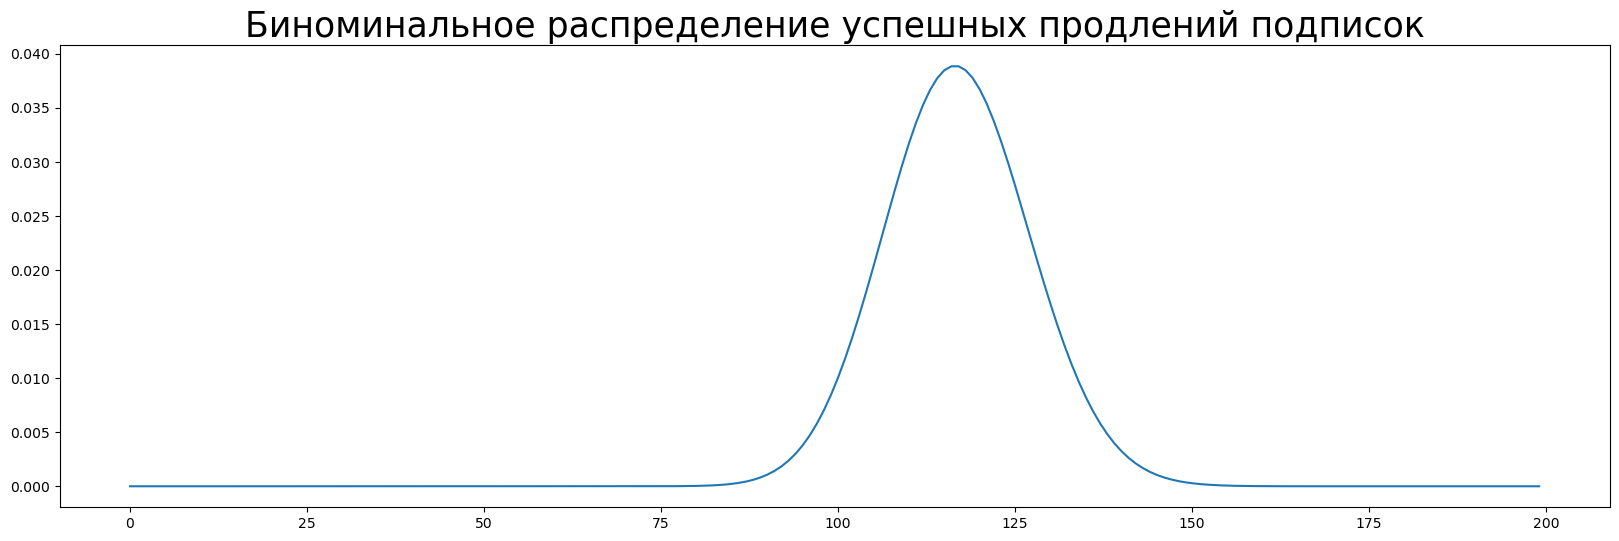

In [76]:
distr = []

for k in range(0, 200):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.figure(figsize=(20,6))
plt.title('Биноминальное распределение успешных продлений подписок', fontsize=25)
ax = plt.plot(range(0, 200), distr,linestyle='-')

<b>Вывод:</b> Минимальное количество разосланных промокодов, необходимых для 100 успешных подписок с вероятностью неуспеха менее 5% и вероятностью успешного продления 1 подписки 0.1 после вручения промокода равна 1169.

#### Задача
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

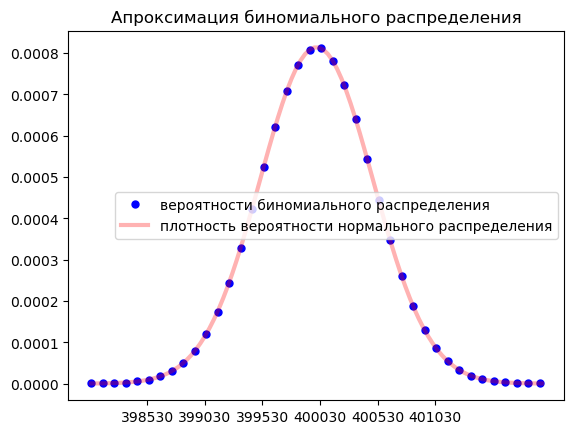

Вероятность, что уведомление откроют не более 399,5 тыс. пользователей: 15.4 %


In [77]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# задаём параметры биномиального распределения
n = 1_000_000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * math.sqrt(n * p * (1 - p)))
right = int(n * p + 4 * math.sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right, 100))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, st.binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = math.sqrt(n * p * (1 - p))

# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 500))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.title("Апроксимация биномиального распределения")
res = plt.show()

print(
    'Вероятность, что уведомление откроют не более 399,5 тыс. пользователей:',
    st.norm(mu, sigma).cdf(399500).round(3) * 100, '%'
)

<b>Ответ:</b> Вероятность, что уведомление откроют не более 399,5 тыс пользователей при 1 млн уведомлений и вероятностью открытия 1 уведомления 40% составляет 15.4%.

### Общий вывод
В ходе проекта были проведены работы:
<br><b>I. Загрузка данных</b>
- Импортированы необходимые для работы библиотеки
- Загруженны данные из файлов `/datasets/users_go.csv`, `/datasets/rides_go.csv` и `/datasets/subscriptions_go.csv`
<br><br>
<b>II. Предобработка данных</b>
<ui>
1. В датасетах пользователей изменен тип столбца `date` на `datetime64[ns]`;
2. Создан столбец `date_month` месяца поездки;
3. Не обнаружено пропусков в датасетах пользователей и поездах;
4. Отфильтрованы явные дубликаты в датасете пользователей;
5. Не обнаружено явных и неявных дубликатов в столбце поездок;
6. Округлены значения расстояния и длительности поездок.
</ui>
<br><br><b>III. Исследование данных</b><br><br>
<ui>
<i>1. Частота встречаемости городов</i>
- Больше всего пользователей сервиса живут в Пятегорске (214);
- Меньше всего пользователей сервиса живут в Москве (167);
- Не найдено никаких выбросов пользователей ни в ккаком городе. Разница количества пользователей в Пятегорске и Москве равна 47.
<br><br><i>2. Соотношение пользователей с подпиской и без подписки</i><br><br>
- Пользователи с платной подпиской равномерно распеределены по городам (от 84 до 94 пользователей);
- Пользователи из Москвы и Омска берут чаще платные подписки, чем в других городах при меньшем количестве обхих пользователей;
- Пользователи из Краснодара и Пятегорска берут реже платные подписки, чем в других городах при большем количестве обхих пользователей.
<br><br><i>3. Возраст пользователей</i><br><br>
- Возраст пользователей нормально распределена с средним (с учетом округления) и медианной равна 25 годам;
- Пользователи до 30 лет чаще предпочитают не брать подписку;
- Пользователи после 30 лет чаще предпочитают брать мещачную подписку;
- Средний возраст пользователей с платной подпиской и без отличаются в каждом городе друго от друга;
- Cредний возраст без подписки выше всех в Москве (25.6 лет);
- Cредний возраст с подпиской выше всех в Краснодаре (26.2 года);
- Cредний возраст без подписки меньше всех в Ростове-на-Дону (24.4 года);
- Cредний возраст с подпиской выше всех в Пятигорске (24.4 года).
</ui>
<br><br><i>4. Расстояние поездок</i><br><br>
- Можно обнаружить две группы поездок: короткие (1500 метров) и длинные (более 1500 метров).
- Наиболее частые поедки имеют расстояния предаления в 3000-3100 метров;
<br><br><b>IV. Объединение данных</b><br><br>
- Объеденены датасеты пользователей, подписок и поездок в один единый датасет;
- Короткие поездки пользователей с платной подпиской распределены от 300 до 2000 метров с пиков на 100 метров;
- Локальных пик частоты коротких поездок (до 1500 метров) для пользователей <u>БЕЗ ПОДПИСКИ</u> раны находится на отметке 700 метров;
- Локальных пик частоты коротких поездок (до 2000 метров) для пользователей <u>С ПОДПИСКОЙ</u> раны находится на отметке 100 метров;
- Длительность поездок пользователей с подпиской и без распределены нормально.
<br><br><b>V. Подсчет выручки</b><br><br>
- Cформирован датасет из всех исходны данных пользователей, подписках и поездках;
- Добавлен столбец суммарной выручки каждого пользователя в кайждый месяц 2021 года.
<br><br><b>VI. Проверка гипотез</b><br><br>
Были проведены гроверки гипотез, в ходе которой были сделаны выводы:
<br>
1. Длительность поездки у пользователей с подпиской выше, чем у пользователей без подписки;
2. Пользователи с подпиской не изнашивают самокаты;
3. Помесячная выручкка с пользователей с подпиской выше помесячной выручкке с пользователей без подпискки;
4. Для проверки эффективности обновления сервера необходимо проверить гипотезу о равенстве двух генеральных совокупностей (до и после обновления сервера) с односторонней альтернативной гипотезой, что количество обращений стало меньше после объявления сервера. 
<br><br><b>VII. Распределения</b><br><br>
Были решены задачи и оформлены ответы:
<ui>
- Минимальное количество разосланных промокодов, необходимых для 100 успешных подписок с вероятностью неуспеха менее 5% и вероятностью успешного продления 1 подписки 0.1 после вручения промокода равна 1169.
- Вероятность, что уведомление откроют не более 399,5 тыс пользователей при 1 млн уведомлений и вероятностью открытия 1 уведомления 40% составляет 15.4%.
</ui>

<br><br><b>VIII. Рекомендации</b><br><br>
В ходе исследования могу порекомендовать следующие точки для развития.
<ui>
- Продолжать делать усилия в сторону увеличения количества подписчиков, так как это приносить хорошую выручку;
- Больше продвигать платную подписку через мобильное приложение делать более удобным подписку интерфесом приложения;
- Использовать уведомления и бесплатные промокоакции на подписку для увеличения числа платных подписок;
- Сделать акцент развивития сервис в городах, где доля платных подписок и возраст пользователей выше, чем в остальных городах (Москва и Омск);
- Необходимо выяснить почему у пользователей без подписки, частно совершают короткие поездки, чтоб улучшить взаимодействие с самокатом.
</ui>